# Carga y comprobaciones
- Carga cables.csv. Revisa tipos, valores nulos por columna, posibles duplicados y los rangos de las
variables.
- Elimina las columnas redudantes (vacías, valores constantes, índices, etc). 

## Primer paso
- Importaciones
- Leer el csv
- Imprimir por pantalla el tamaño

In [11]:
import pandas as pd
import numpy as np
import warnings, time
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)
#df1 para la primera parte en la que obligatoriamente he de eliminar valores perdidos
#df2 para la segunda parte en la que tengo que modificar los datos
#df3 para la parte final en la que hago los cambios definitivos y entreno los modelos
df1 = pd.read_csv("cables.csv", index_col=0)
df2 = pd.read_csv("cables.csv", index_col=0)
df3 = pd.read_csv("cables.csv", index_col=0)
#Print para comprobar que se ha cargado
print("Tamaño del dataframe:")
print(df1.shape)

Tamaño del dataframe:
(490, 7)


## Segundo paso
- Revisa tipos, valores nulos, etc
- Elimina columnas redundantes

In [2]:
# Número de valores perdidos
nan = df1.isna().sum()
print("Hay estos valores que son NaN en cada columna: \n", nan)

Hay estos valores que son NaN en cada columna: 
 N     5
R    19
S    13
T    16
U     7
G     1
L     0
dtype: int64


In [3]:
#Revisamos las filas que están duplicadas
dup = df1.duplicated().sum()
print("Hay estas filas duplicadas: ", dup)

Hay estas filas duplicadas:  0


In [4]:
#Comprobamos el rango de las variables
df1.describe()

,N,R,S,T,U,G,L
count,485.000000,471.000000,477.000000,474.000000,483.000000,489.000000,490.000000
mean,35.053608,499.023312,2239.754717,313.253165,3916.645963,1674.640082,1734.773469
std,28.297293,248.861906,6214.925633,320.326768,2230.142048,1170.295112,1155.587275
min,1.000000,60.000000,1.000000,3.000000,84.000000,-2103.000000,80.000000
25%,16.000000,325.000000,256.000000,106.000000,1992.000000,923.000000,916.500000
50%,27.000000,458.330000,729.000000,212.000000,3985.000000,1697.000000,1500.000000
75%,45.000000,633.330000,2025.000000,401.000000,5920.000000,2443.000000,2222.750000
max,200.000000,1673.330000,102400.000000,2800.000000,7668.000000,4946.000000,7675.000000


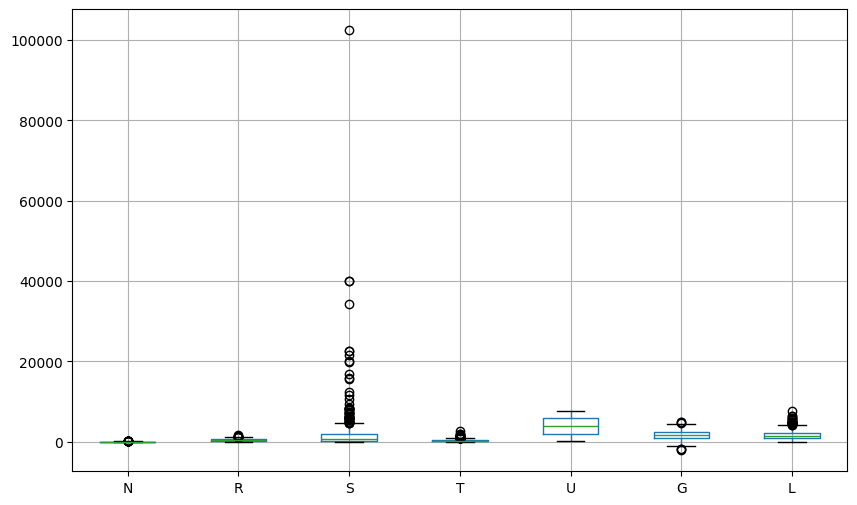

         N        R         S       T       U       G     L
4     76.0   863.33    5776.0   745.0   974.0  2377.0  3411
8     83.0   460.00    6889.0   211.0  6064.0  2784.0  1885
10    92.0   793.33    8464.0   629.0  1613.0   594.0  1855
35    90.0   341.67    8100.0   116.0  7367.0  -361.0  1623
40    80.0  1166.67    6400.0  1361.0  6746.0  2421.0  3430
42   141.0   966.67   19881.0   934.0   183.0   950.0  6465
54    79.0   416.67    6241.0   173.0  2891.0   762.0  2557
69    69.0   466.67    4761.0   217.0  5558.0  1753.0  3096
79   108.0      NaN   11664.0   374.0   326.0  3672.0  2764
109   74.0   613.33    5476.0   376.0  2360.0  1621.0  1675
131   77.0   560.00    5929.0   313.0  2943.0  1615.0  1880
136   70.0   591.67    4900.0   350.0  7381.0   932.0  3221
137   75.0   346.67    5625.0   120.0  3423.0  2885.0  1531
138   91.0   996.67    8281.0   993.0  3714.0  -503.0  2702
147   78.0   675.00    6084.0     NaN  7482.0 -1784.0  2594
160   70.0   250.00    4900.0    62.0  5

In [5]:
#Hacemos un boxplot para ver todos los outliers
import matplotlib.pyplot as plt

df1.boxplot(figsize=(10,6))
plt.show()
# Ejemplo: detectar outliers usando el rango intercuartílico (IQR)
Q1 = df1['S'].quantile(0.25)
Q3 = df1['S'].quantile(0.75)
IQR = Q3 - Q1

outliers = df1[(df1['S'] < Q1 - 1.5*IQR) | (df1['S'] > Q3 + 1.5*IQR)]
print(outliers)



## Resumen de como ha quedado el dataframe después de esto

In [6]:
print("=== Resumen del dataset ===")
print("Tamaño del DataFrame:", df1.shape)
print("\nColumnas:", df1.columns.tolist())
print("\nValores faltantes por columna:\n", df1.isna().sum())
print("\nDuplicados totales:", df1.duplicated().sum())
print("\nEstadísticos descriptivos:\n", df1.describe())

=== Resumen del dataset ===
Tamaño del DataFrame: (490, 7)

Columnas: ['N', 'R', 'S', 'T', 'U', 'G', 'L']

Valores faltantes por columna:
 N     5
R    19
S    13
T    16
U     7
G     1
L     0
dtype: int64

Duplicados totales: 0

Estadísticos descriptivos:
                 N            R              S            T            U  \
count  485.000000   471.000000     477.000000   474.000000   483.000000   
mean    35.053608   499.023312    2239.754717   313.253165  3916.645963   
std     28.297293   248.861906    6214.925633   320.326768  2230.142048   
min      1.000000    60.000000       1.000000     3.000000    84.000000   
25%     16.000000   325.000000     256.000000   106.000000  1992.000000   
50%     27.000000   458.330000     729.000000   212.000000  3985.000000   
75%     45.000000   633.330000    2025.000000   401.000000  5920.000000   
max    200.000000  1673.330000  102400.000000  2800.000000  7668.000000   

                 G            L  
count   489.000000   490.00000

# Análisis exploratorio
- Distribución de L (histograma) y relaciones L–N y L–R (gráficos de dispersión con tendencia).
- Segmenta por tamaño de municipio (es decir, repite los gráficos anteriores para los municipios con
menos habitantes que la media y para los municipios con más habitantes que la media) y
comprueba visualmente si hay diferencias.
- Razona qué señales parecen explicar mejor L.
- Identifica los puntos anómalos (outliers) en los gráficos de dispersión

## Histograma

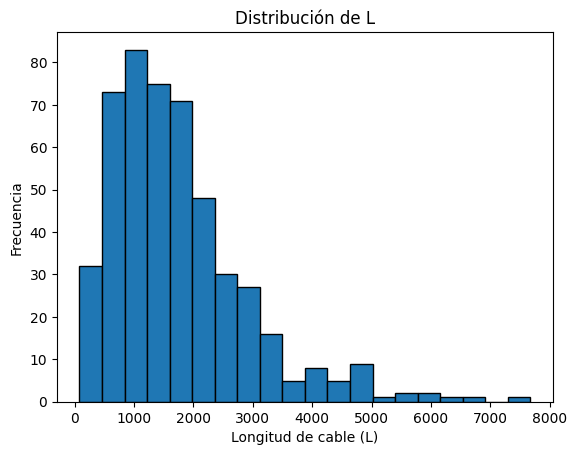

In [7]:
plt.hist(df1['L'], bins=20, edgecolor='black')
plt.title("Distribución de L")
plt.xlabel("Longitud de cable (L)")
plt.ylabel("Frecuencia")
plt.show()

plt.show()

## Gráficos de dispersión

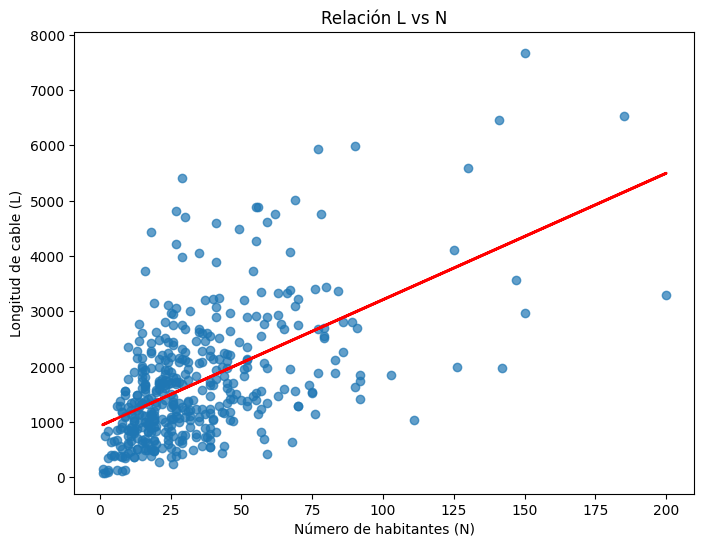

In [ ]:
# Scatter plot L vs N

# Línea de tendencia (regresión lineal simple)
X_1 = df1.dropna()[['N']]
y_1 = df1.dropna()['L']

model = LinearRegression()
model.fit(X_1,y_1)

#Los puntos
plt.figure(figsize=(8,6))
plt.scatter(X_1, y_1, alpha=0.7, label="Datos")

#La línea
plt.plot(X_1, model.predict(X_1), color='red', linewidth=2, label="Tendencia")
plt.title("Relación L vs N")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.show()



In [9]:
# Scatter plot L vs R
plt.scatter(df1['R'], df1['L'], alpha=0.7)
# Línea de tendencia
df1.dropna()
m, b = np.polyfit(df1['R'], df1['L'], 1)
plt.plot(df1['R'], m*df1['R'] + b, color='red', linewidth=2)
plt.title("Relación L vs R")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.show()

LinAlgError: SVD did not converge in Linear Least Squares

## Gráficos de dispersión separados por la media

Gráfico de L vs N

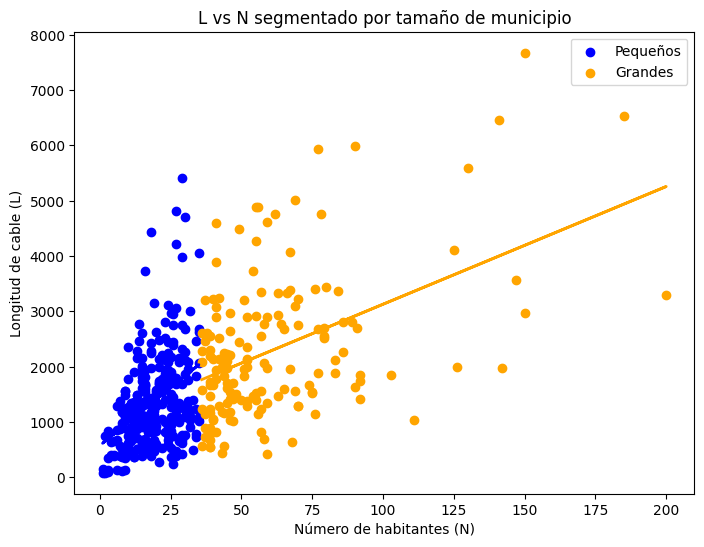

In [11]:
# Calculamos la media
media = np.mean(df1['N'])

#Separamos en municipios grandes y pequeños
dfSmall = df1.dropna()[df1['N'] < media]
dfBig = df1.dropna()[df1['N'] >= media]

#Gráfico de L vs N
plt.figure(figsize=(8,6))

#Municipios pequeños
plt.scatter(dfSmall['N'], dfSmall['L'], color='blue', label="Pequeños")
m,b = np.polyfit(dfSmall['N'], dfSmall['L'], 1)
plt.plot(dfSmall['N'], m*dfSmall['N'] + b, color='blue', linewidth=2)

#Municipios grandes
plt.scatter(dfBig['N'], dfBig['L'], color='orange', label="Grandes")
m,b = np.polyfit(dfBig['N'], dfBig['L'], 1)
plt.plot(dfBig['N'], m*dfBig['N'] + b, color='orange', linewidth=2)

plt.title("L vs N segmentado por tamaño de municipio")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()


Gráfico de L vs R

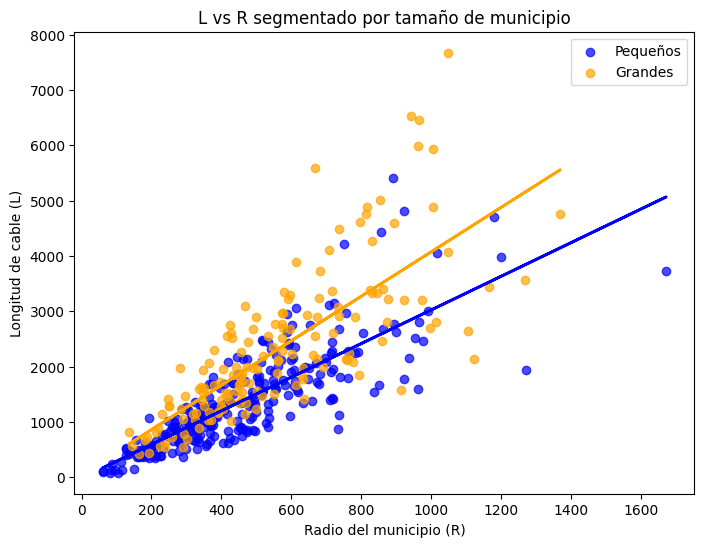

In [12]:
plt.figure(figsize=(8,6))

#Municipios pequeños
XSmall = dfSmall[['R']]
ySmall = dfSmall['L']
modelSmall = LinearRegression().fit(XSmall, ySmall)
plt.scatter(XSmall, ySmall, color='blue', alpha=0.7, label='Pequeños')
plt.plot(XSmall, modelSmall.predict(XSmall), color='blue', linewidth=2)

#Municipios pequeños
XBig = dfBig[['R']]
yBig = dfBig[['L']]
modelBig = LinearRegression().fit(XBig, yBig)
plt.scatter(XBig, yBig, color='orange',alpha=0.7,label="Grandes")
plt.plot(XBig, modelBig.predict(XBig), color='orange', linewidth=2)

plt.title("L vs R segmentado por tamaño de municipio")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()

### Razonamiento a incluir en el documento
Dado que los puntos en el gráfico de dispersión están distribuidos más próximos a la línea, hay una correlación mayor entre ambas variables que entre L y N, por lo que la variable R se podría decir que explica mejor los valores de la variable L

Identifiación de puntos anómalos en los gráficos de dispersión. Se usa el rango intercuartílico para detectar outliers en cada grupo

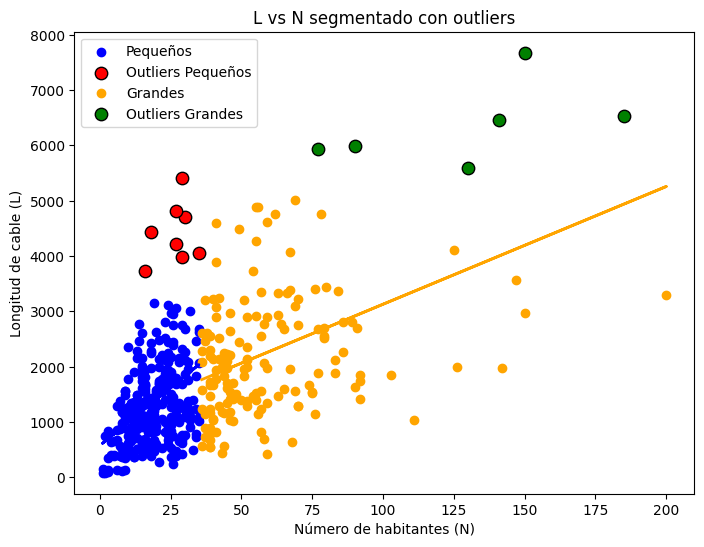

In [13]:
#Media de N
media = df1['N'].mean()

dfSmall = df1.dropna()[df1['N'] < media]   # menos habitantes que la media
dfBig = df1.dropna()[df1['N'] >= media]  # igual o más habitantes que la media

# Función auxiliar para detectar los outliers mediante el uso de IQR
def detectar_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    # True para los outliers
    return (series < Q1 - 1.5*IQR) | (series > Q3 + 1.5*IQR)

# L vs N
plt.figure(figsize=(8,6))

# Pequeños
outliersSmall = detectar_outliers(dfSmall['L'])
plt.scatter(dfSmall['N'], dfSmall['L'], color='blue', label='Pequeños')
plt.scatter(dfSmall['N'][outliersSmall], dfSmall['L'][outliersSmall],
            color='red', edgecolor='black', s=80, label='Outliers Pequeños')  # outliers resaltados
m, b = np.polyfit(dfSmall['N'], dfSmall['L'], 1)
plt.plot(dfSmall['N'], m*dfSmall['N'] + b, color='blue', linewidth=2)

# Grandes
outliersBig = detectar_outliers(dfBig['L'])
plt.scatter(dfBig['N'], dfBig['L'], color='orange', label='Grandes')
plt.scatter(dfBig['N'][outliersBig], dfBig['L'][outliersBig],
            color='green', edgecolor='black', s=80, label='Outliers Grandes')  # outliers resaltados
m, b = np.polyfit(dfBig['N'], dfBig['L'], 1)
plt.plot(dfBig['N'], m*dfBig['N'] + b, color='orange', linewidth=2)

plt.title("L vs N segmentado con outliers")
plt.xlabel("Número de habitantes (N)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()


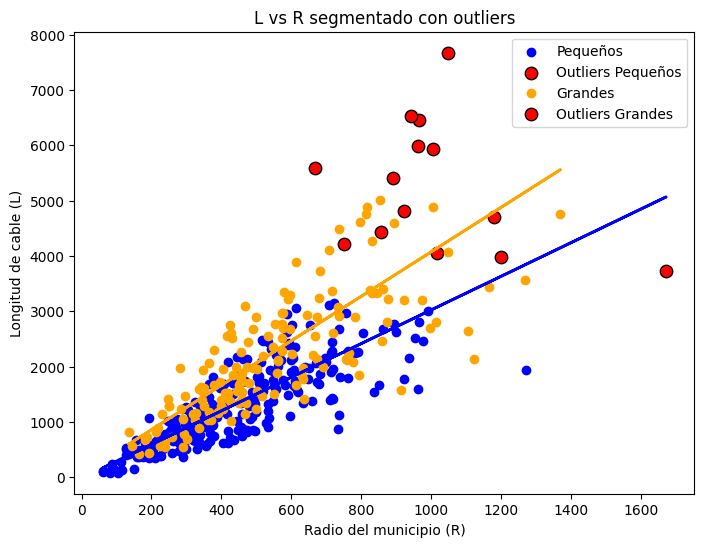

In [14]:
# 4️⃣ L vs R segmentado con outliers
plt.figure(figsize=(8,6))

# Pequeños
outliersSmall = detectar_outliers(dfSmall['L'])
plt.scatter(dfSmall['R'], dfSmall['L'], color='blue', label='Pequeños')
plt.scatter(dfSmall['R'][outliersSmall], dfSmall['L'][outliersSmall],
            color='red', edgecolor='black', s=80, label='Outliers Pequeños')
m, b = np.polyfit(dfSmall['R'], dfSmall['L'], 1)
plt.plot(dfSmall['R'], m*dfSmall['R'] + b, color='blue', linewidth=2)

# Grandes
outliersBig = detectar_outliers(dfBig['L'])
plt.scatter(dfBig['R'], dfBig['L'], color='orange', label='Grandes')
plt.scatter(dfBig['R'][outliersBig], dfBig['L'][outliersBig],
            color='red', edgecolor='black', s=80, label='Outliers Grandes')
m, b = np.polyfit(dfBig['R'], dfBig['L'], 1)
plt.plot(dfBig['R'], m*dfBig['R'] + b, color='orange', linewidth=2)

plt.title("L vs R segmentado con outliers")
plt.xlabel("Radio del municipio (R)")
plt.ylabel("Longitud de cable (L)")
plt.legend()
plt.show()

# Tratamiento de valores perdidos
- Empieza con una estrategia simple (media o mediana) y valida con K-fold
- Si procede, compara con KNNImputer o IterativeImputer.

## Separación de variables predictoras y variables objetivo

Se asume que L es la variable objetivo (lo pone el ejercicio)

In [15]:
X = df2.drop(columns=['L'])
y = df2['L']

## Imputación de valores faltantes

Usando un `SimpleImputer` con la media

In [16]:
imputer  = SimpleImputer(strategy="median")

XImputed = imputer.fit_transform(X)

## Validación con `K-Fold`

Y usando validación cruzada para comprobar calidad del modelo lineal con los datos imputados

In [17]:
model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, XImputed, y, cv=kf, scoring='r2')

print("Resultados de validación cruzada (R²):")
print(scores)
print("Media del R²:", np.mean(scores))

Resultados de validación cruzada (R²):
[0.59333992 0.73602262 0.69479988 0.70049667 0.53903154]
Media del R²: 0.6527381258864686


Voy a probar también con KNNImputer, y validar también los resultados con KFold

In [ ]:
# Crear el imputer
imputer_knn = KNNImputer(n_neighbors=5)  # puedes ajustar el número de vecinos

# Aplicar al dataset
X_knn = imputer_knn.fit_transform(X)

# Convertir a DataFrame
X_knn = pd.DataFrame(X_knn, columns=X.columns)


In [19]:
# Definimos modelo y validación
model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Validar usando los datos imputados
scores = cross_val_score(model, X_knn, y, cv=kf, scoring='r2')

print("R² en cada fold:", scores)
print("Media del R²:", np.mean(scores))


R² en cada fold: [0.62361108 0.76013289 0.72899768 0.71162641 0.51806332]
Media del R²: 0.6684862759278191


In [20]:
X = pd.DataFrame(X_knn, columns=X.columns)


Me quedo con KNN, por lo que reasigno X (sacada de df2) para que en adelante no se contengan valores NaN

# Escalado/Normalización
- Usando StandardScaler o MinMaxScaler, especialmente si empleas KNN o modelos con
regularización.

Voy a hacer una parte con StandarScaler y otra con MinMaxScaler para poder comparar los resultados y escoger el que mejor vaya

In [21]:
print(X.columns)
print(y)

Index(['N', 'R', 'S', 'T', 'U', 'G'], dtype='object')
1       686
2      2087
3       734
4      3411
5       346
       ... 
486    3985
487    1571
488    1682
489    1663
490     404
Name: L, Length: 490, dtype: int64


## StandardScaler

In [ ]:

scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X)

# Convertir a DataFrame para inspeccionar
X_std = pd.DataFrame(X_std, columns=X.columns)
print("Valores escalados con StandardScaler:")
print(X_std.describe())

Valores escalados con StandardScaler:
                  N             R             S             T             U  \
count  4.900000e+02  4.900000e+02  4.900000e+02  4.900000e+02  4.900000e+02   
mean  -3.987740e-17 -5.437827e-17 -2.175131e-17  4.350262e-17  2.900174e-17   
std    1.001022e+00  1.001022e+00  1.001022e+00  1.001022e+00  1.001022e+00   
min   -1.204480e+00 -1.795558e+00 -3.625318e-01 -9.830104e-01 -1.728552e+00   
25%   -6.719152e-01 -6.909406e-01 -3.195792e-01 -6.515561e-01 -8.646436e-01   
50%   -2.813679e-01 -1.590880e-01 -2.437491e-01 -3.122100e-01  2.926871e-02   
75%    3.577094e-01  5.483374e-01 -3.228983e-02  2.859861e-01  9.012985e-01   
max    5.860875e+00  4.804856e+00  1.634520e+01  7.846301e+00  1.693243e+00   

                  G  
count  4.900000e+02  
mean  -7.250436e-17  
std    1.001022e+00  
min   -3.234796e+00  
25%   -6.441532e-01  
50%    2.036123e-02  
75%    6.568398e-01  
max    2.799551e+00  


## MinMaxScaler

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler_mm = MinMaxScaler()
X_mm = scaler_mm.fit_transform(X)

# Convertir a DataFrame
X_mm = pd.DataFrame(X_mm, columns=X.columns)
print("Valores escalados con MinMaxScaler:")
print(X_mm.describe())


Valores escalados con MinMaxScaler:
                N           R           S           T           U           G
count  490.000000  490.000000  490.000000  490.000000  490.000000  490.000000
mean     0.170477    0.272037    0.021698    0.111335    0.505159    0.536064
std      0.141680    0.151660    0.059914    0.113375    0.292543    0.165887
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.075377    0.167356    0.002571    0.037540    0.252472    0.429316
50%      0.130653    0.247934    0.007109    0.075974    0.513713    0.539438
75%      0.221106    0.355113    0.019766    0.143725    0.768559    0.644914
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000


## Visualización de resultados

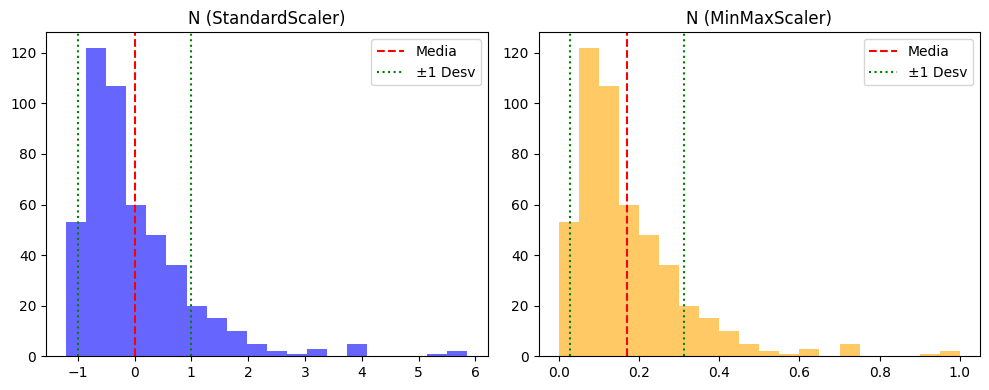

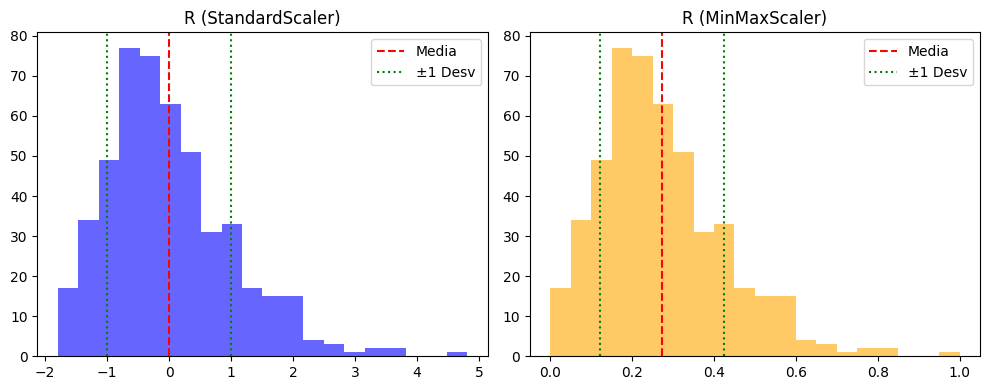

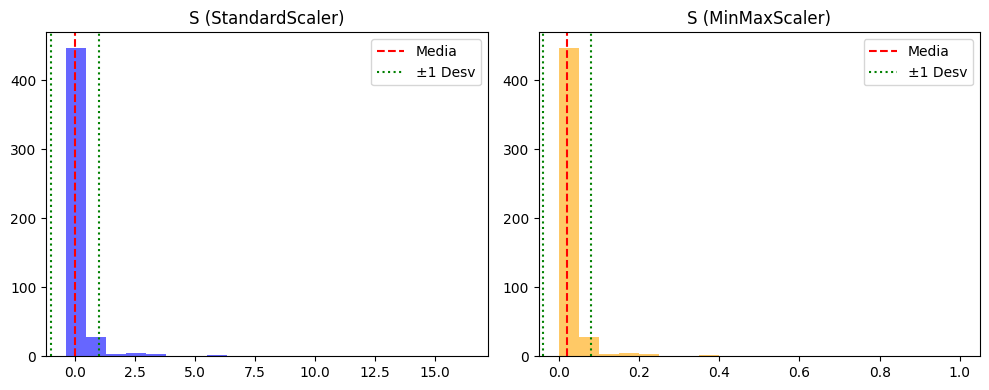

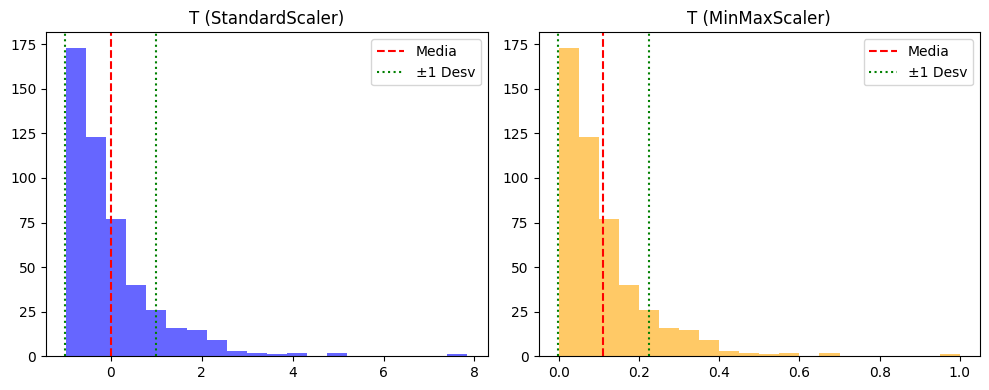

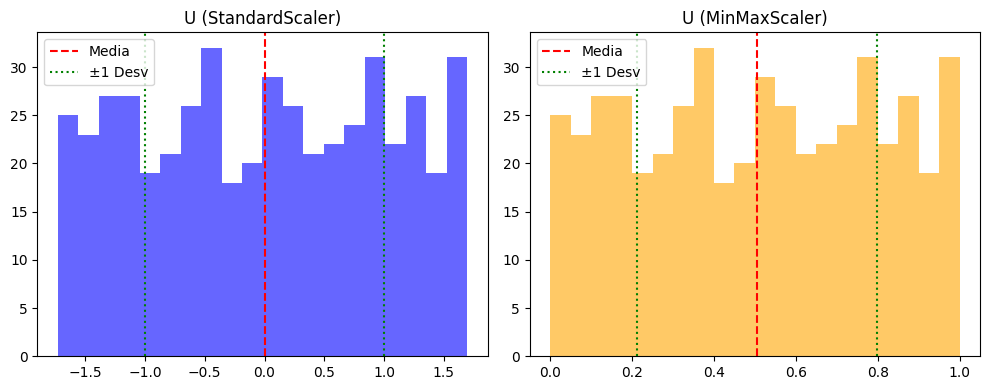

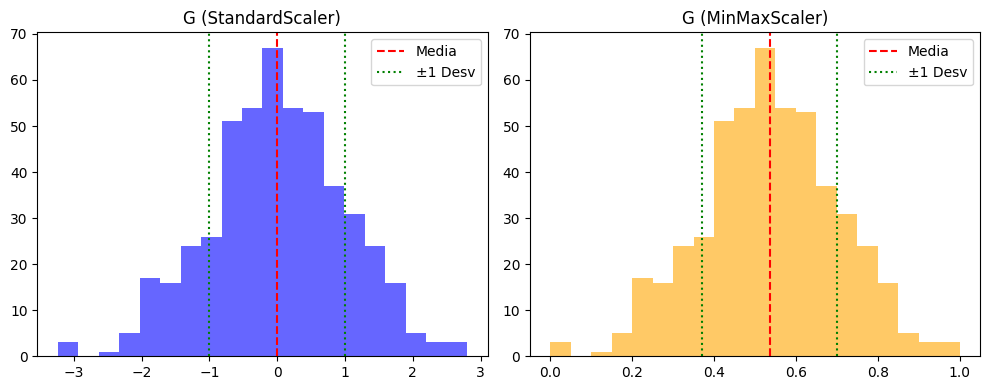

In [24]:

for col in X.columns:
    plt.figure(figsize=(10,4))
    
    # Histograma StandardScaler
    plt.subplot(1,2,1)
    plt.hist(X_std[col], bins=20, color='blue', alpha=0.6)
    mean_std = np.mean(X_std[col])
    std_std = np.std(X_std[col])
    plt.axvline(mean_std, color='red', linestyle='--', label='Media')
    plt.axvline(mean_std + std_std, color='green', linestyle=':', label='±1 Desv')
    plt.axvline(mean_std - std_std, color='green', linestyle=':')
    plt.title(f'{col} (StandardScaler)')
    plt.legend()
    
    # Histograma MinMaxScaler
    plt.subplot(1,2,2)
    plt.hist(X_mm[col], bins=20, color='orange', alpha=0.6)
    mean_mm = np.mean(X_mm[col])
    std_mm = np.std(X_mm[col])
    plt.axvline(mean_mm, color='red', linestyle='--', label='Media')
    plt.axvline(mean_mm + std_mm, color='green', linestyle=':', label='±1 Desv')
    plt.axvline(mean_mm - std_mm, color='green', linestyle=':')
    plt.title(f'{col} (MinMaxScaler)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



# Variables irrelevantes y outliers
Detecta y justifica la eliminación de variables distractoras o redundantes mediante información
mutua.

## Información mutua con la variable objetivo
Para calcular que variables aportan más a L. Aquellas variables cuyo valor sea cercano a 0 podrían ser **distractoras**

In [25]:
# Calcular información mutua entre cada columna de X y y
mi = mutual_info_regression(X, y, random_state=42)

# Convertir a Serie para ordenarlas fácilmente
mi_series = pd.Series(mi, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)

print("Información mutua con L:")
print(mi_series)


Información mutua con L:
T    0.681376
R    0.673854
N    0.198278
S    0.144616
U    0.007780
G    0.000000
dtype: float64


## Matriz de correlación
Para visualizar los resultados

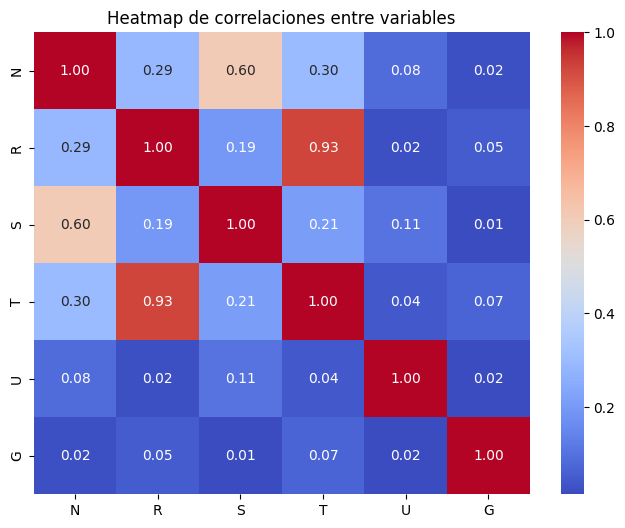

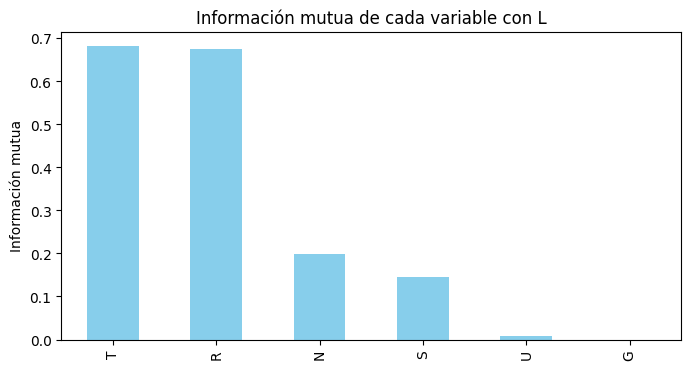

In [27]:
# Matriz de correlación absoluta
corr_matrix = X.corr().abs()
import seaborn as sns

# Heatmap de correlaciones
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de correlaciones entre variables")

plt.figure(figsize=(8,4))
mi_series.plot(kind='bar', color='skyblue')
plt.title("Información mutua de cada variable con L")
plt.ylabel("Información mutua")
plt.show()


## Reflexión para el informe
Como T y R tienen una alta correlación entre sí, me quedo sólo con T. Como S y N tienen también una alta correlación entre sí, me quedo solo con N. Como U y G no aportan nada a L, no las utilizo.

# Dos Modelos

## Selección de las variables apropiadas
Vamos a coger X e Y de df3, que es un dataframe nuevo e independiente de df2 para evitar cualquier dato que haya sido modificado (df3 tiene los datos tal cual vienen en el csv sin imputación ni escalado)

In [34]:
X = df3.drop(columns=['R', 'S', 'U', 'G', 'L'])
y = df3['L']

## Separación en Train y Test
Se hace una partición estratifiacda de train y test

In [18]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

## Creación del KFold para comprobación

In [19]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Pipeline para LinearRegression

In [20]:
pipe_lr = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

## Resultados de LinearRegression

In [30]:

r2_lr = cross_val_score(pipe_lr, X_train, y_train, cv=kf, scoring='r2')
rmse_lr = np.sqrt(-cross_val_score(pipe_lr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))

print("Linear Regression R²:", r2_lr.mean())
print("Linear Regression RMSE:", rmse_lr.mean())

Linear Regression R²: 0.5880202300005326
Linear Regression RMSE: 738.3177497344543


## Pipeline para RandomForest

In [32]:

from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', MinMaxScaler()),
    ('model', RandomForestRegressor(random_state=42))
])

rf_params = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 5, 10],
    'model__min_samples_split': [2, 5]
}



Grid para hiperparámetros
'best_model_RF=grid_rf.best_estimator_'

In [33]:
from sklearn.model_selection import GridSearchCV

grid_rf = GridSearchCV(pipe_rf, rf_params, cv=kf, scoring='r2')
grid_rf.fit(X, y)
bestModel = grid_rf.best_estimator_
rmse_scores = np.sqrt(-cross_val_score(bestModel, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
print("Random Forest mejor R²:", grid_rf.best_score_)
print("Random Forest mejor RMSE:", rmse_scores.mean())
print("Mejores parámetros RF:", grid_rf.best_params_)



Random Forest mejor R²: 0.6375038664361636
Random Forest mejor RMSE: 737.9708299540424
Mejores parámetros RF: {'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}


En base a esto se utiliza el mejor modelo